# Garbage Classification

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import InputLayer, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.layers import RandomFlip, RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tqdm.keras import TqdmCallback
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from google.colab import drive

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Carregando e separando os dados

In [23]:
!ls "/content/drive/MyDrive/Lucas/Garbage classification"

'Garbage classification'


In [24]:
base_path = '/content/drive/MyDrive/Lucas/Garbage classification'

df_all = pd.DataFrame()
for dirname, _, filenames in os.walk(base_path):
    paths = [dirname + '/' + filename for filename in filenames if '.jpg' in filename]
    folder_name = os.path.split(dirname)[-1]
    df_all = pd.concat([df_all, pd.DataFrame({'path': paths, 'label': folder_name})], ignore_index=True)

df_all

,path,label
0,/content/drive/MyDrive/Lucas/Garbage classific...,glass
1,/content/drive/MyDrive/Lucas/Garbage classific...,glass
2,/content/drive/MyDrive/Lucas/Garbage classific...,glass
3,/content/drive/MyDrive/Lucas/Garbage classific...,glass
4,/content/drive/MyDrive/Lucas/Garbage classific...,glass
...,...,...
2522,/content/drive/MyDrive/Lucas/Garbage classific...,trash
2523,/content/drive/MyDrive/Lucas/Garbage classific...,trash
2524,/content/drive/MyDrive/Lucas/Garbage classific...,trash
2525,/content/drive/MyDrive/Lucas/Garbage classific...,trash


In [25]:
# Número de imagens por classe (dataset desbalanceado)
df_all['label'].value_counts().sort_index()

cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137
Name: label, dtype: int64

In [26]:
# Número de classes
n_classes = len(df_all['label'].unique())
n_classes

6

In [27]:
# Lista das classes
classes = list(df_all['label'].unique())
classes

['glass', 'metal', 'plastic', 'paper', 'cardboard', 'trash']

In [28]:
# Reduzindo o dataframe para 125 imagens por classe
df = df_all.head(0)

for c in classes:
  subset = df_all[df_all['label'] == c]
  subset = subset.sample(125, random_state=0)
  df = pd.concat([df, subset], ignore_index=True)

df['label'].value_counts()


glass        125
metal        125
plastic      125
paper        125
cardboard    125
trash        125
Name: label, dtype: int64

In [29]:
# Separando conjunto de treinamento, validação e teste
df_train, df_test = train_test_split(df, test_size=25*n_classes, stratify=df['label'], random_state=42)
df_train, df_val = train_test_split(df_train, test_size=25*n_classes, stratify=df_train['label'], random_state=42)

df_train_small, _ = train_test_split(df_train, train_size=25*n_classes, stratify=df_train['label'], random_state=42)

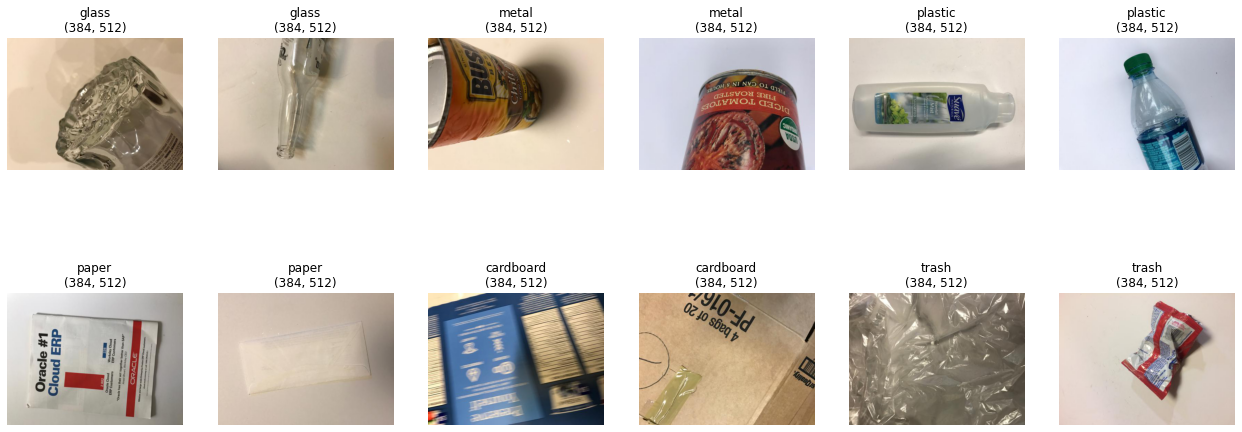

In [30]:
plt.figure(figsize=(22,18))
for i, label in enumerate(classes):
  for j in range(2):
    plt.subplot(4,6, 2*i+j+1)
    img = plt.imread(df_train['path'][df['label'] ==  label].iloc[j])
    plt.imshow(img)
    plt.title(f"{label}\n{img.shape[:2]}")
    plt.axis("off")

In [31]:
# Função para preparar o tf.data.Dataset
try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE 

def create_dataset(df, img_size, batch_size):
  paths = df['path']
  labels = df['label'].map(classes.index) # ordinal encoder
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  ds = ds.map(lambda x, y: (tf.io.read_file(x), y))
  ds = ds.map(lambda x, y: (tf.io.decode_jpeg(x, channels=3), y))
  ds = ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
  ds = ds.cache().batch(batch_size).prefetch(AUTOTUNE)
  return ds

In [32]:
img_size = (80, 80)
batch_size = 64

ds_train_small = create_dataset(df_train_small, img_size, batch_size)
ds_train = create_dataset(df_train, img_size, batch_size)
ds_val = create_dataset(df_val, img_size, batch_size)
ds_test = create_dataset(df_test, img_size, batch_size)

# auxiliar print
print('-'*30)
print('datasets division')
print('-'*30)
print(f'Train (small) = {len(df_train_small)}')
print(f'Train (full) = {len(df_train)}')
print(f'Val = {len(df_val)}')
print(f'Test = {len(df_test)}')

------------------------------
datasets division
------------------------------
Train (small) = 150
Train (full) = 450
Val = 150
Test = 150


## Treinamento com df_train_small


In [33]:
callbacks = [ReduceLROnPlateau(factor=0.2, patience=10, verbose=0), EarlyStopping(patience=30, verbose=0)]

In [34]:
def plots(history):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
  plt.legend();
  plt.grid();

### a) Sem a utilização de data augmentation

#### i) Modelo descongelado

In [35]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_1 = Model(i, x)

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 31.6 s, sys: 955 ms, total: 32.5 s
Wall time: 42.7 s


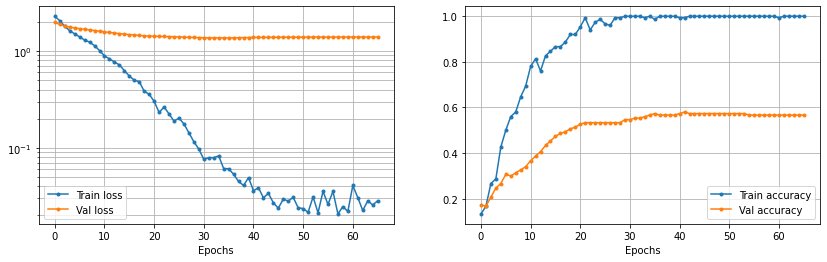

In [36]:
%%time
epochs = 100
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_1 = model_1.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_1)

#### ii) Modelo congelado

In [37]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_2 = Model(i, x)

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 12.3 s, sys: 830 ms, total: 13.1 s
Wall time: 28.9 s


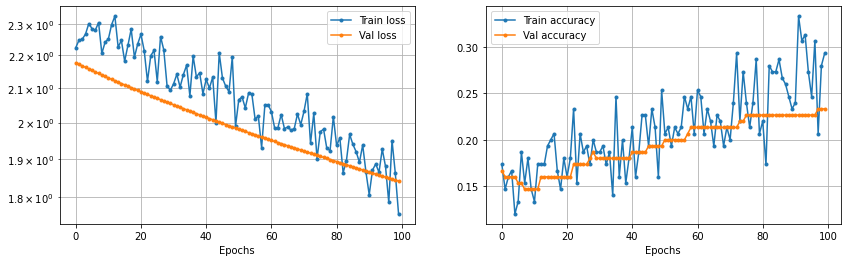

In [38]:
%%time
epochs = 100
lr = 1e-5
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_2 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_2)

#### iii) Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 43.8 s, sys: 1.16 s, total: 45 s
Wall time: 1min 1s


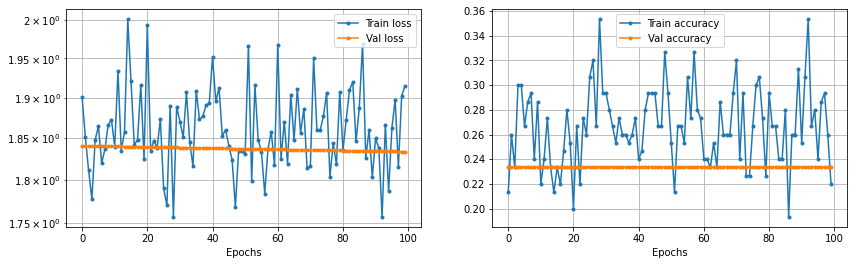

In [39]:
%%time
base_model.trainable = True

epochs = 100
lr = 1e-8
model_2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_3 = model_2.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_3)

### b) Com a utilização de data augmentation

In [40]:
# Camada de data augmentation
data_augmentation = Sequential(
  [
    RandomTranslation(height_factor=0.15, width_factor=0.15),
    RandomFlip(mode='horizontal')
  ],
  name='data_augmentation',
)

#### i) Modelo descongelado
```



In [41]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_3 = Model(i, x)

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 2min 1s, sys: 16 s, total: 2min 17s
Wall time: 1min 50s


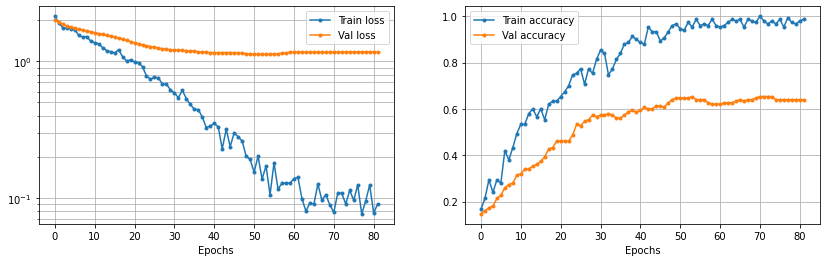

In [42]:
%%time
epochs = 100
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_4 = model_3.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_4)

#### Modelo congelado

In [43]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = False

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_4 = Model(i, x)

model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 80, 80, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 1min 55s, sys: 19.5 s, total: 2min 14s
Wall time: 1min 49s


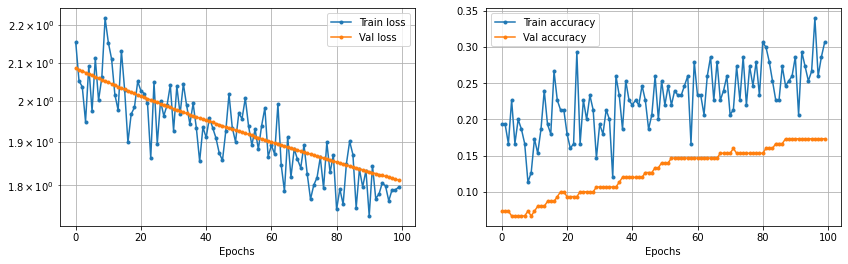

In [44]:
%%time
epochs = 100
lr = 1e-5

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_5 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_5)

#### Fine tuning

0epoch [00:00, ?epoch/s]

CPU times: user 2min 27s, sys: 19.7 s, total: 2min 47s
Wall time: 2min 16s


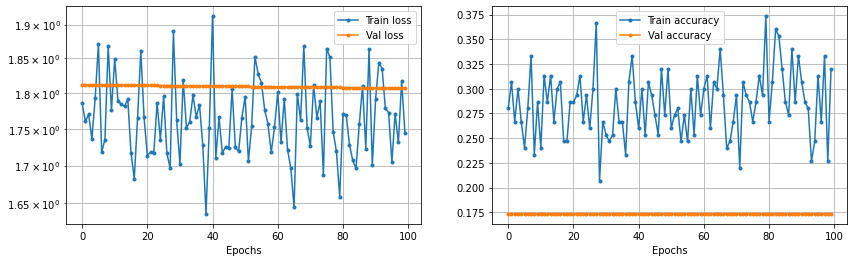

In [45]:
%%time
base_model.trainable = True

epochs = 100
lr = 1e-8

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_6 = model_4.fit(ds_train_small, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_6)

## Treinamento com dataset de treinamento completo

#### **Baseline**

In [46]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 48.7 s, sys: 1.02 s, total: 49.7 s
Wall time: 1min 15s


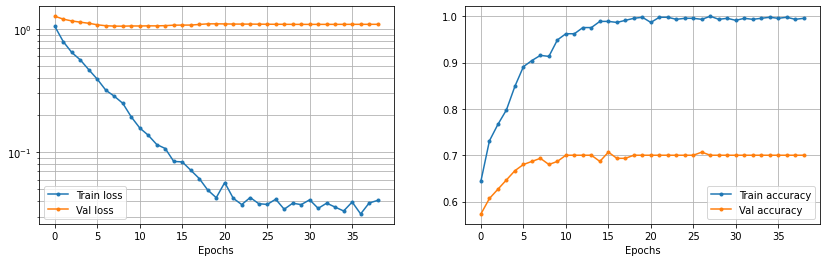

In [47]:
%%time
epochs = 100
lr = 1e-5

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_7 = model_1.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_7)

#### Data augmentation

In [48]:
model_3

0epoch [00:00, ?epoch/s]

CPU times: user 4min 22s, sys: 37 s, total: 4min 59s
Wall time: 4min 3s


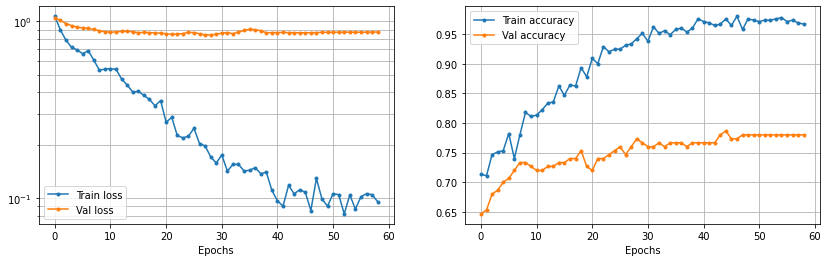

In [49]:
%%time
epochs = 100
lr = 1e-5

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_8 = model_3.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_8)

#### Alteração do tamanho da imagem

In [50]:
new_img_size = (200, 200)
batch_size = 64

ds_train_r = create_dataset(df_train, new_img_size, batch_size)
ds_val_r = create_dataset(df_val, new_img_size, batch_size)
ds_test_r = create_dataset(df_test, new_img_size, batch_size)

In [51]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_5 = Model(i, x)

model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1229

0epoch [00:00, ?epoch/s]

CPU times: user 6min 7s, sys: 8.92 s, total: 6min 16s
Wall time: 8min 33s


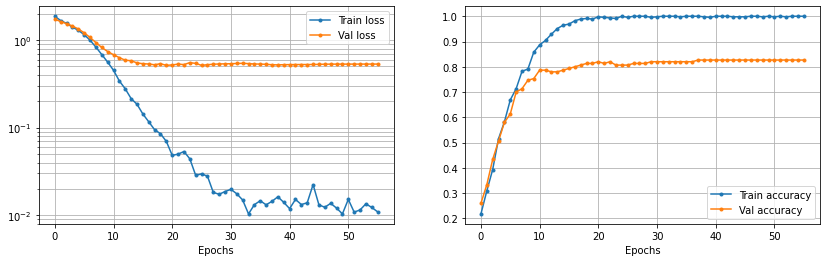

In [52]:
%%time
epochs = 100
lr = 1e-5

model_5.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_9 = model_5.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_9)

#### ResNet

In [53]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_6 = Model(i, x)

model_6.summary()

219055592/219055592 [==============================] - 1s 0us/step
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1536)              0  

0epoch [00:00, ?epoch/s]

CPU times: user 1min 29s, sys: 7.02 s, total: 1min 36s
Wall time: 2min 9s


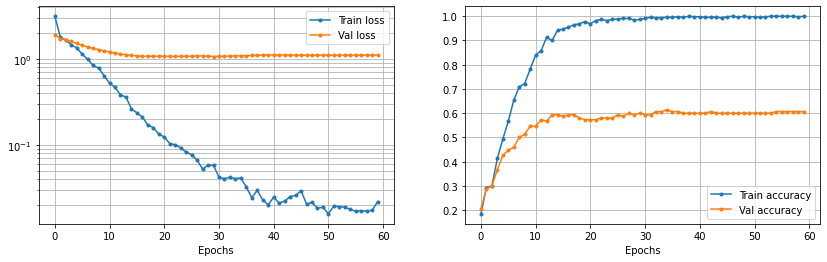

In [54]:
%%time
epochs = 100
lr = 1e-5

model_6.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_10 = model_6.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_10)

#### Data augmentation + alteração no tamanho da imagem

In [55]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_7 = Model(i, x)

model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_7 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_7 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 11min 8s, sys: 51.8 s, total: 12min
Wall time: 14min 8s


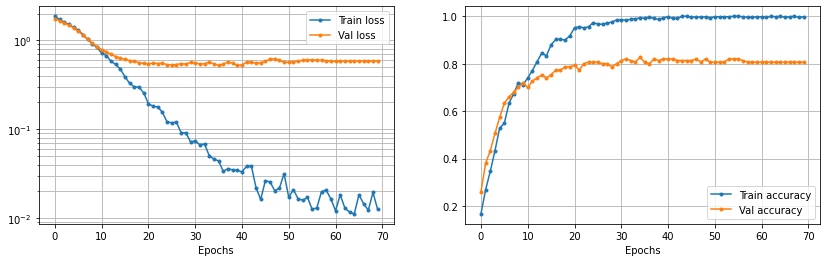

In [56]:
%%time
epochs = 100
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_11 = model_7.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_11)

#### Data augmentation + Resnet

In [57]:
input_shape = img_size + (3,) # (80, 80, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_8 = Model(i, x)

model_8.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 80, 80, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_8 (TFOpLam  (None, 80, 80, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                     

0epoch [00:00, ?epoch/s]

CPU times: user 7min 30s, sys: 1min 11s, total: 8min 42s
Wall time: 7min 28s


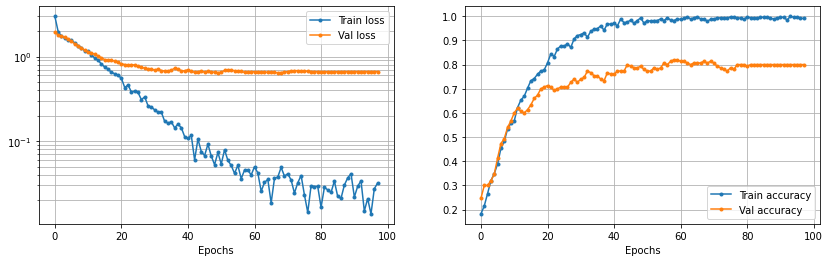

In [58]:
%%time
epochs = 100
lr = 1e-5
model_8.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_12 = model_8.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_12)

#### Alteração no tamanho da imagem + ResNet

In [59]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = preprocess_input(i)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_9 = Model(i, x)

model_9.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 200, 200, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 1536)              0         
                                                           

0epoch [00:00, ?epoch/s]

CPU times: user 2min 59s, sys: 1min 10s, total: 4min 9s
Wall time: 6min 11s


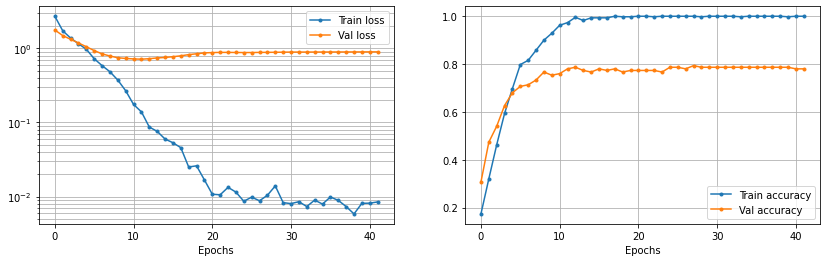

In [60]:
%%time
epochs = 100
lr = 1e-5

model_9.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_13 = model_9.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_13) 

#### Data augmentation + alteração no tamanho da imagem + ResNet

In [61]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = InceptionResNetV2(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_10 = Model(i, x)

model_10.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 200, 200, 3)      0         
 mbda)                                                           
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                    

0epoch [00:00, ?epoch/s]

CPU times: user 5min 25s, sys: 1min 39s, total: 7min 4s
Wall time: 7min 24s


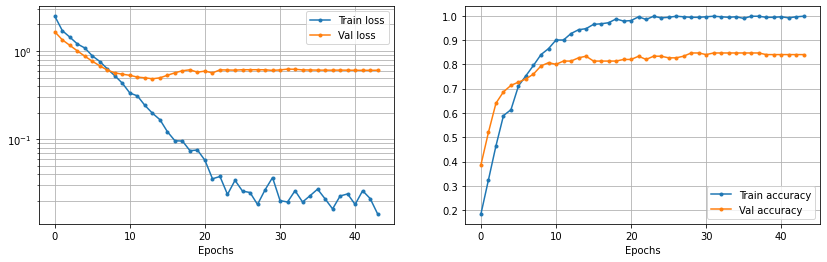

In [62]:
%%time
epochs = 100
lr = 1e-5

model_10.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_14 = model_10.fit(ds_train_r, validation_data=ds_val_r, epochs=epochs, callbacks=callbacks + [TqdmCallback(verbose=0)], verbose=0)

plots(history_14)

## Retreinamento (train + val)

In [63]:
# Dataset de treinamento + val
ds_retr = create_dataset(pd.concat([df_train, df_val], ignore_index=True), new_img_size, batch_size)

In [64]:
input_shape = new_img_size + (3,) # (200, 200, 3)

base_model = Xception(include_top=False, input_shape=input_shape, pooling='avg')
base_model.trainable = True

i = Input(shape=input_shape)
x = data_augmentation(i)
x = preprocess_input(x)
x = base_model(x, training=False)

x = Dropout(0.3)(x)
x = Dense(6, activation='softmax')(x)
model_7 = Model(i, x)

model_7.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 tf.math.truediv_11 (TFOpLam  (None, 200, 200, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_11 (TFOpLa  (None, 200, 200, 3)      0         
 mbda)                                                           
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                          

0epoch [00:00, ?epoch/s]

CPU times: user 20min 59s, sys: 1min 35s, total: 22min 35s
Wall time: 28min 13s


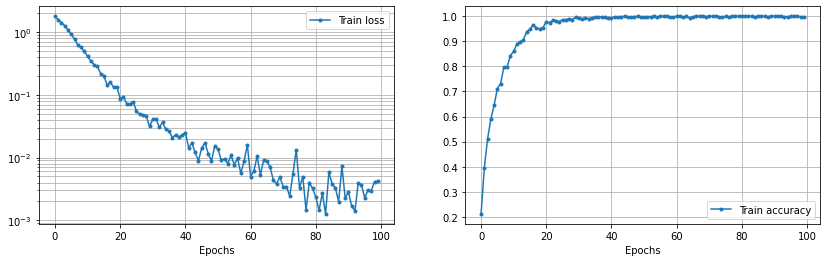

In [65]:
# Melhor modelo: data augmentation + alteração no tamanho da imagem (utilizando Xception) - "model_7"
%%time

epochs = 100
lr = 1e-5

model_7.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

history_retr = model_7.fit(ds_retr, epochs=epochs, callbacks=[TqdmCallback(verbose=0)], verbose=0)

plots(history_retr)

## Análise de resultados (test)

### Matriz de confusão (test)


In [66]:
# Predição das imagens com o melhor modelo - "model-7"
test_pred = model_7.predict(ds_test_r) 

3/3 [==============================] - 1s 233ms/step


In [67]:
# Valores reais
test_true = df_test['label']

In [68]:
# Transformando as probabilidades preditos para comparar com as labels do df_test
input_array = np.argmax(test_pred, axis=1)
rows = len(input_array)
classified_list = [None]*rows

for i in range(rows):
  classified_list[i] = classes[input_array[i]]

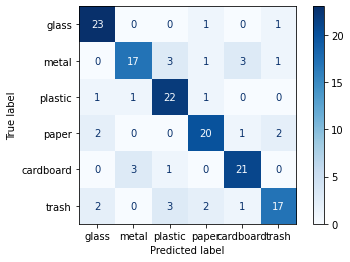

In [69]:
cm = confusion_matrix(test_true, classified_list)

display = ConfusionMatrixDisplay(cm, display_labels=classes)
display.plot(cmap=plt.cm.Blues)
plt.show()

### Classificações erradas (test)

In [70]:
df_results = pd.DataFrame({'Imagem_Real': test_true, 'Predicão': classified_list, 'Predição_Correta': (test_true == classified_list)})
df_results = df_results[df_results['Predição_Correta'] == False]

df_results.head(20)

,Imagem_Real,Predicão,Predição_Correta
365,plastic,glass,False
123,glass,plastic,False
64,glass,plastic,False
300,plastic,glass,False
47,glass,metal,False
381,paper,trash,False
660,trash,paper,False
678,trash,metal,False
674,trash,metal,False
22,glass,metal,False


In [78]:
df_results['Predição_Correta'].shape

# Número de classificações erradas = 30

(30,)

#### Imagens de algumas (3) classificações erradas

(-0.5, 511.5, 383.5, -0.5)

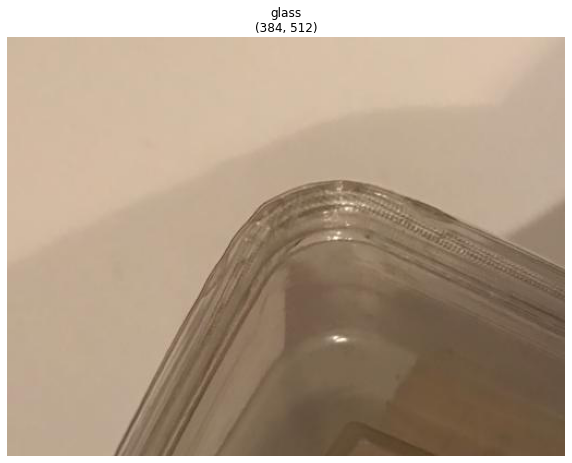

In [79]:
# Imagem 365
pred = 'glass' # Predição feita pelo modelo
img = plt.imread(df['path'].iloc[365]) # Imagem real: 'plastic'
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.title(f'{pred}\n{img.shape[:2]}')
plt.axis('off')

(-0.5, 511.5, 383.5, -0.5)

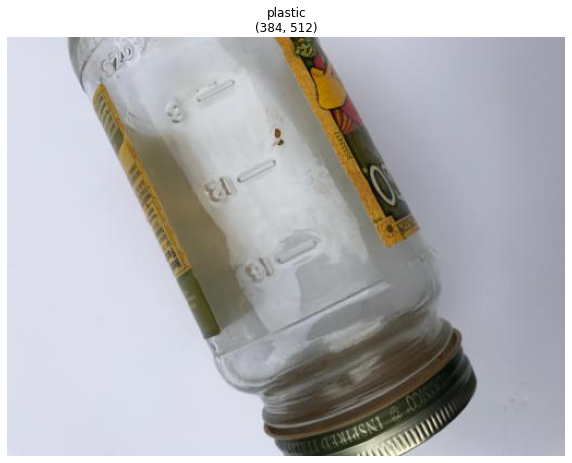

In [80]:
# Imagem 123
pred = 'plastic' # Predição feita pelo modelo
img = plt.imread(df['path'].iloc[123]) # Imagem real: 'glass'
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.title(f'{pred}\n{img.shape[:2]}')
plt.axis('off')

(-0.5, 511.5, 383.5, -0.5)

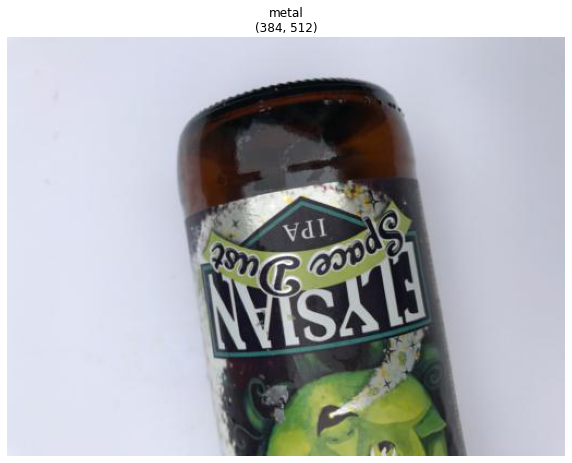

In [82]:
# Imagem 64
pred = 'metal' # Predição feita pelo modelo
img = plt.imread(df['path'].iloc[47]) # Imagem real: 'glass'
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.title(f'{pred}\n{img.shape[:2]}')
plt.axis('off')

## Comentários e discussão

- Foi possível observar que a variação da taxa de aprendizado influencia diretamente nas predições, fazendo com que, quando temos 2 valores muito próximos, um convirja e o outro não, tornando a predição errônea.

- Aparantemente, o dataset está bastante sujeito a overfitting. Contudo, ao utilizarmos camadas de data augmentation durante a predição, temos que esse overfitting diminui, tornando menor a diferença entre a acurácia de treino e teste, que é o que almejamos.

- Os modelos instaurados no trabalho também necessitam de uma grande possibilidade de processamento, visto que, mesmo com GPU fornecida pelo Colab, os treinamentos para 100/200 épocas, são muito lentos.

- Além disso, explorar uma nova biblioteca, como o TensorFlow/Keras, na contramão dos outros trabalhos e também trabalhar com processamento de imagens, tornam o trabalho muito interessante.

- Treinei o modelo 7 (data augmentation + tamanho maior) como melhor modelo pois antes tinha treinado com mais épocas (300) e esse tinha sido o melhor, contudo, ao rodar uma última vez com 100 épocas para entregar o trabalho, o modelo 7 não se mostrou o melhor.